In [1]:
# Parkinsonics Motor Measures Data Analysis - PDQ39
# Kevin Li
# 04.05.2020

import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as smt
import statsmodels.api as sm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import missingno as msno
import os

## Exploratory Data Analysis of PDQ39 score

In [2]:
# Load PDQ39 scores
pdqdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures\PDQ39_all_visits_08262016.xlsx')

# Load randomization patient ID list
IDdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Parkinsonics_RandID_ List_DID.xlsx')
IDdf=IDdf[:-5]
S_group=IDdf.loc[IDdf['First Intervention']=='S']
D_group=IDdf.loc[IDdf['First Intervention']=='D']
M_gen=IDdf.loc[IDdf['Gender']=='M']
F_gen=IDdf.loc[IDdf['Gender']=='F']

#Clean datatypes
IDdf['ID']=IDdf['ID'].astype(float)
IDsort=IDdf['ID'].sort_values().reset_index()['ID']

# Slice to obtain only category subscores for each patient for each tp
# 6 timepoints, 8 subscores per timepoint, 39 questions
subcols=[0];
for i in range(6):
    subcols+=range(40+8*i+39*i, 40+8*(i+1)+39*i)

pdqdf=pdqdf.iloc[:,subcols]


In [3]:
miss_count=0
tot_count=0
for col in range(len(pdqdf.columns)-4):
    for row in range(26):
        tot_count+=1
        if np.isnan(pdqdf.iloc[row, col]):
            miss_count+=1
                
miss_ratio=miss_count/tot_count
miss_ratio

0.024786324786324785

# All Participants/Groupwise Plots - Spaghetti

In [4]:
# We have 8 subscores --> 8 plots for each of S/D
# Put all of the columns of each subscore into one list, 8 lists total
mob=['ID', 'Mobility_BL', 'Mobility_V01', 'Mobility_V02', 'Mobility_V03', 'Mobility_V04', 'Mobility_V05']
adl=['ID', 'ADL_BL', 'ADL_V01', 'ADL_V02', 'ADL_V03', 'ADL_V04', 'ADL_V05' ]
emo=['ID', 'EmotionalWell_BL', 'EmotionalWell_V01', 'EmotionalWell_V02', 'EmotionalWell_V03', 'EmotionalWell_V04', 'EmotionalWell_V05']
sti=['ID', 'Stigma_BL', 'Stigma_V01', 'Stigma_V02', 'Stigma_V03', 'Stigma_V04', 'Stigma_V05']
soc=['ID', 'SocialSupport_BL', 'SocialSupport_V01', 'SocialSupport_V02', 'SocialSupport_V03', 'SocialSupport_V04', 'SocialSupport_V05']
cog=['ID', 'CognitiveImp_BL', 'CognitiveImp_V01', 'CognitiveImp_V02', 'CognitiveImp_V03', 'CognitiveImp_V04', 'CognitiveImp_V05']
com=['ID', 'Communication_BL', 'Communication_V01', 'Communication_V02', 'Communication_V03', 'Communication_V04', 'Communication_V05']
bod=['ID', 'BodyDiscomfort_BL', 'BodyDiscomfort_V01', 'BodyDiscomfort_V02', 'BodyDiscomfort_V03', 'BodyDiscomfort_V04', 'BodyDiscomfort_V05']
SI=['ID', 'SI_BL', 'SI_V01', 'SI_V02', 'SI_V03', 'SI_V04', 'SI_V05']

subscores=[mob, adl, emo, sti, soc, cog, com, bod, SI]

Calculate and Insert Summary Index Subscores

In [5]:
pdq_SI=pd.DataFrame()

for tp in range(6):
    tot=pdqdf.iloc[:, range(8*tp+1,8*tp+9)].sum(axis=1)
    avg=tot/8
    pdq_SI=pd.concat([pdq_SI, avg], axis=1)

pdq_SI.index=IDsort
pdq_SI.columns=SI[1:]   

# Append to pdqdf
pdqdf=pd.merge(pdqdf, pdq_SI, on='ID')
pdqdf=pd.merge(pdqdf, IDdf, on='ID')

Implement Last Observation Carried Forward for Missing Data Points

In [6]:
# Step 1: Check BL for each subscore, drop patients with nan values for that subscore & SI
miss_ID=[0]
miss_sub=['blank']
miss_group=[0]
copydf=pdqdf.copy()
for i in range(8):
    score=subscores[i]
    for ID in range(26):
        if np.isnan(copydf.iloc[ID, i+1]):
            if miss_sub[0]=='blank':
            # If the missing items list is unpopulated
                miss_sub[0]=i
                miss_ID[0]=[pdqdf['ID'][ID]]
                miss_group[0]=[pdqdf['First Intervention'][ID]]
            else:
            # The missing items list has elements
                count1=0
                for m_subs in miss_sub:
                    if m_subs==i:
                        count2=0
                        for m_ID in miss_ID[-1]:
                            if m_ID==pdqdf['ID'][ID]:
                                count2+=1
                        if count2==0:
                            miss_ID[-1].append(pdqdf['ID'][ID])
                            miss_group[-1].append(pdqdf['First Intervention'][ID])
                        count1+=1
                if count1==0:
                    miss_sub.append(i)
                    miss_ID.append([pdqdf['ID'][ID]])
                    miss_group.append([pdqdf['First Intervention'][ID]])
            for tp in range(1,7):
                copydf.loc[ID, score[tp]]=float('nan')
                copydf.loc[ID, SI[tp]]=float('nan')
                
            
# Step 2: Check V1-V5 for each subscore, carry forward last observation in place of missing data
for i in range(9):
    subtps=subscores[i]
    subdf=copydf[subtps]
    # Iterate through each entry of each subscore df, search for nan values
    for tp in range(2,7):
        for ID in range(26):
             # If nan, set equal to value at previous tp
            if np.isnan(subdf.iloc[ID, tp]):
                if miss_sub[0]=='blank':
             # If the missing items list is unpopulated
                     miss_sub[0]=i
                     miss_ID[0]=[pdqdf['ID'][ID]]
                     miss_group[0]=[pdqdf['First Intervention'][ID]]
                else:
             # The missing items list has elements
                    count1=0
                    for j in range(len(miss_sub)):
                        if miss_sub[j]==i:
                            count2=0
                            for m_ID in miss_ID[j]:
                                if m_ID==pdqdf['ID'][ID]:
                                    count2+=1
                            if count2==0:
                                miss_ID[j].append(pdqdf['ID'][ID])
                                miss_group[j].append(pdqdf['First Intervention'][ID])
                            count1+=1
                    if count1==0:
                        miss_sub.append(i)
                        miss_ID.append([pdqdf['ID'][ID]])
                        miss_group.append([pdqdf['First Intervention'][ID]])
                subdf.iloc[ID, tp]=subdf.iloc[ID, tp-1]
    if i==0:
        locfdf=subdf
    if i!=0:    
        locfdf=pd.concat([locfdf, subdf.iloc[:, 1:]], axis=1, sort=False)
        
locfdf=pd.merge(locfdf, IDdf, on='ID')

C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Modify format of non-LOCF data to match the format of LOCF, to replicate analyses

In [7]:
for i in range(9):
    if i==0:
        origdf=pdqdf[subscores[i]]
    else:
        origdf=pd.merge(origdf, pdqdf[subscores[i]], on='ID')
        
origdf=pd.concat([origdf, pdqdf[['Age', 'Gender', 'Hoehn & Yahr', 'First Intervention']]], axis=1)

In [8]:
# Stratify PDQ by group

# LOCF data:
S_pdq_locf=locfdf.loc[locfdf['First Intervention']=='S']
D_pdq_locf=locfdf.loc[locfdf['First Intervention']=='D']

# Original data:
S_pdq_orig=origdf.loc[origdf['First Intervention']=='S']
D_pdq_orig=origdf.loc[origdf['First Intervention']=='D']


# Missing data visualisation

Utilize missingno to create nullity matrix and nullity correlation heatmap between all vars

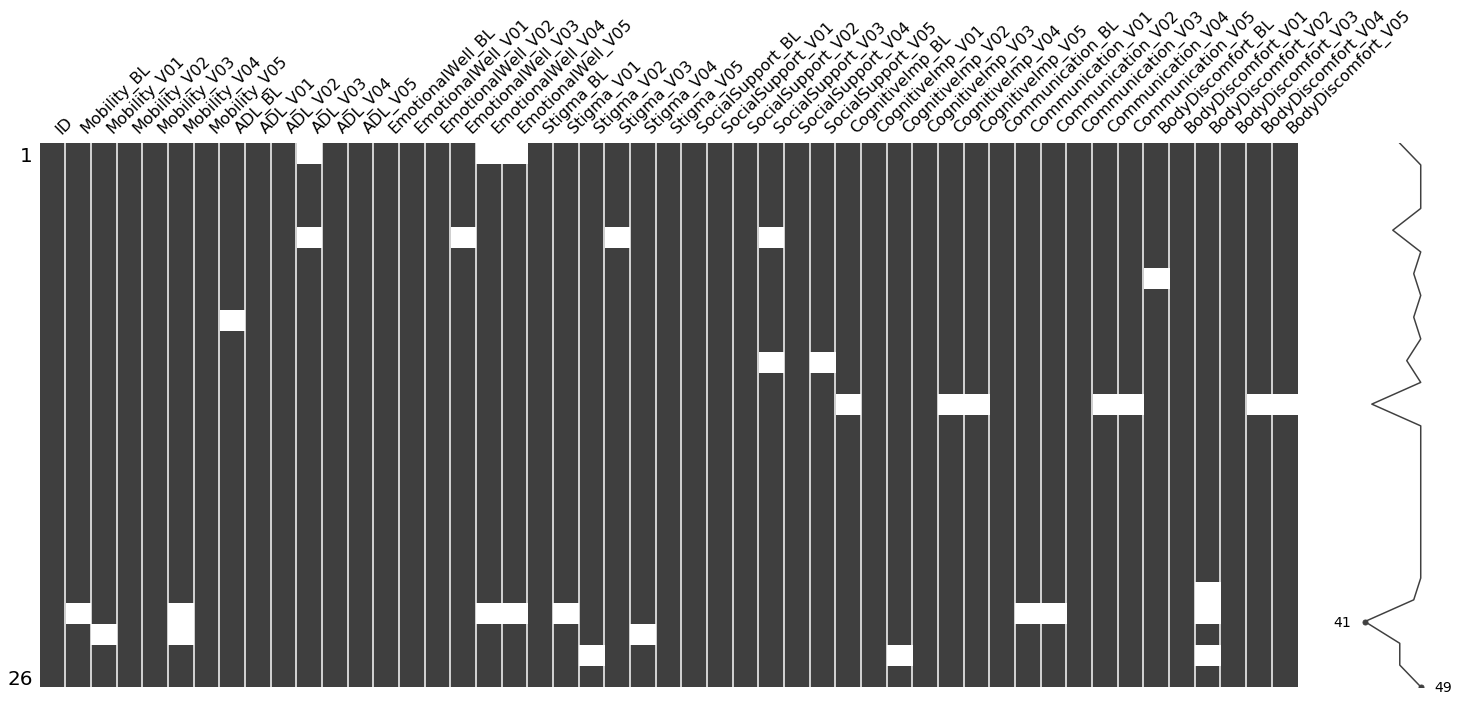

In [19]:
msno.matrix(origdf.iloc[:, :-10])

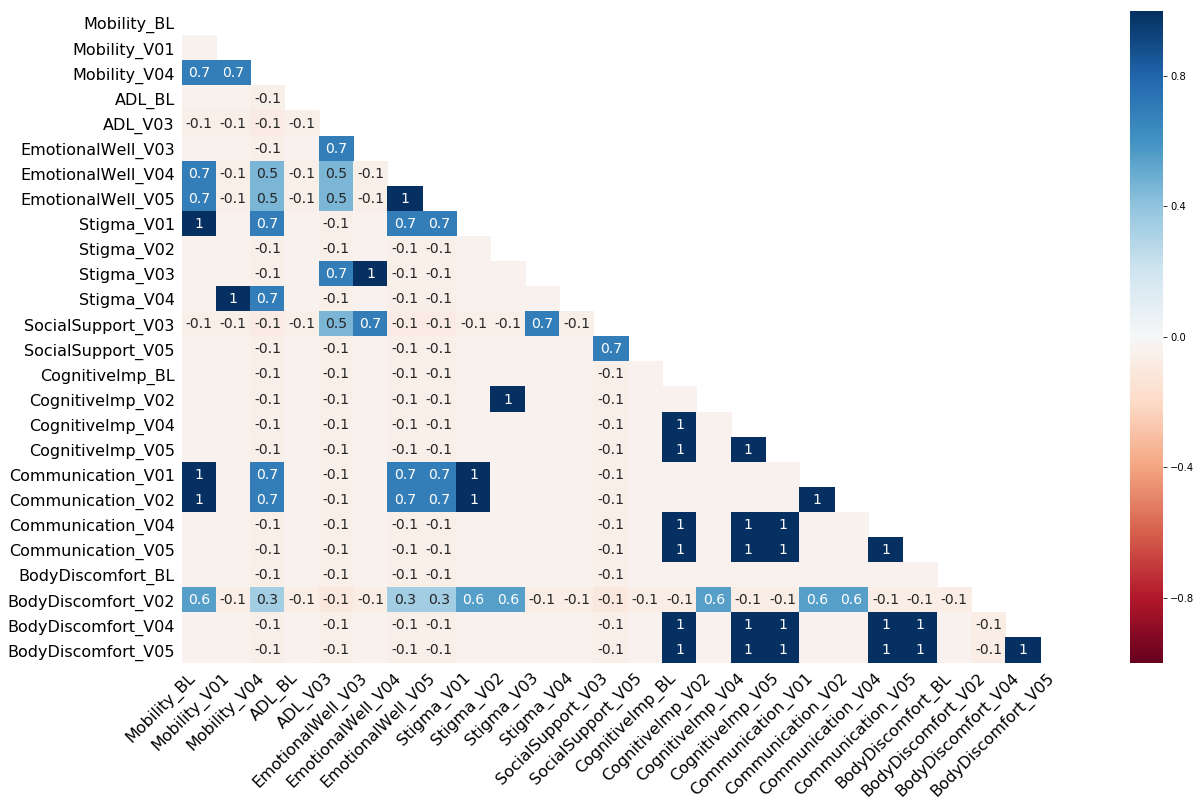

In [21]:
msno.heatmap(origdf.iloc[:, :-10])

# Start-end paired T-tests

One p value for each subscore

In [20]:
# Create 4 initial dfs to append to within each loop

# LOCF data:
S_se_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])
D_se_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='SI'
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_pdq_locf[subscores[i]].iloc[:, np.r_[1,6]]
    D_se=D_pdq_locf[subscores[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        temppdq=sedflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(temppdq.iloc[:, 0], temppdq.iloc[:, 1], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(temppdq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(temppdq.iloc[:, 1])

        if j==0:            
            S_se_locf=pd.concat([S_se_locf, tempdf], sort=False)
        elif j==1:
            D_se_locf=pd.concat([D_se_locf, tempdf], sort=False)
    count+=1
    
# Original data:
S_se_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])
D_se_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='SI'
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_pdq_orig[subscores[i]].iloc[:, np.r_[1,6]]
    D_se=D_pdq_orig[subscores[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        temppdq=sedflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(temppdq.iloc[:, 0], temppdq.iloc[:, 1], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(temppdq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(temppdq.iloc[:, 1])

        if j==0:            
            S_se_orig=pd.concat([S_se_orig, tempdf], sort=False)
        elif j==1:
            D_se_orig=pd.concat([D_se_orig, tempdf], sort=False)
    count+=1

In [43]:
S_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_StartEnd_S_LOCF.xlsx')
D_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_StartEnd_D_LOCF.xlsx')

S_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_StartEnd_S_Orig.xlsx')
D_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_StartEnd_D_Orig.xlsx')

S group - Singing First

LOCF Data Plots


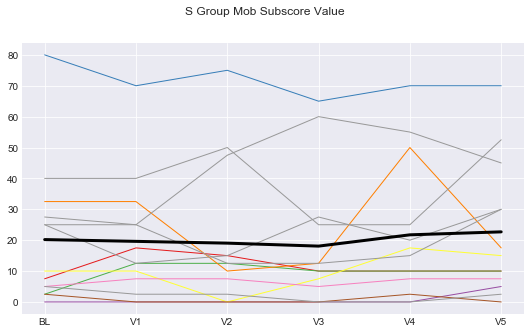

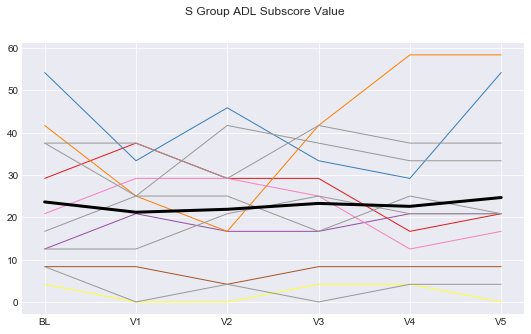

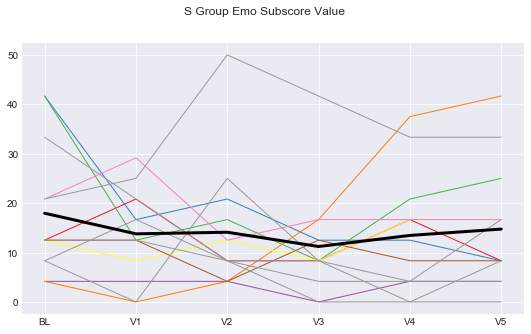

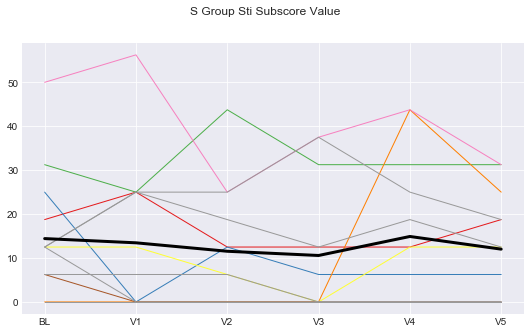

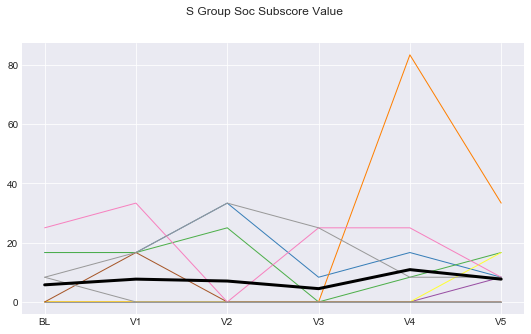

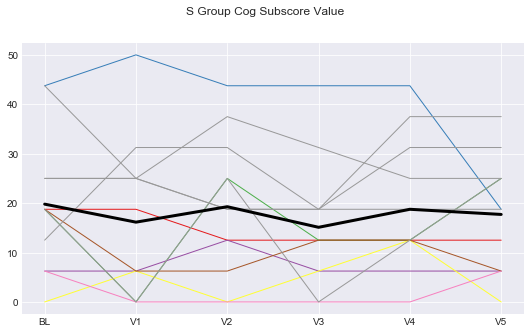

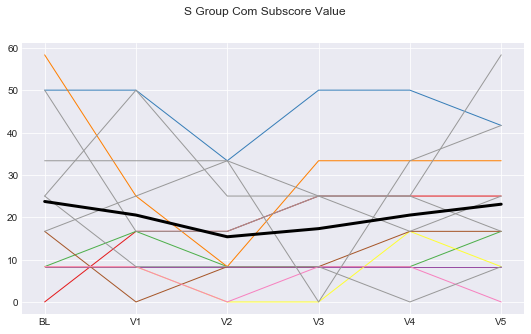

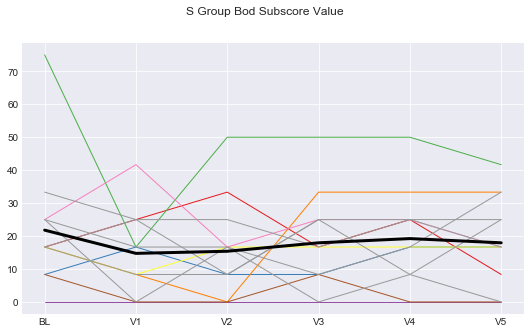

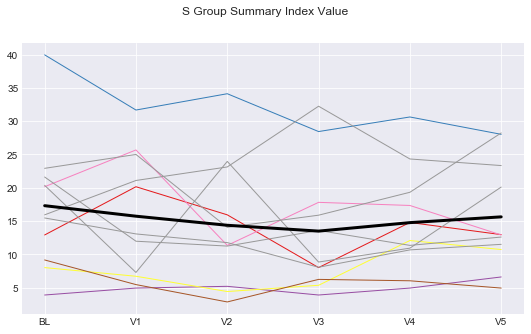

Original Data Plots


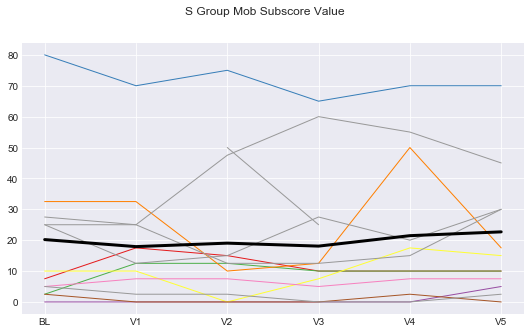

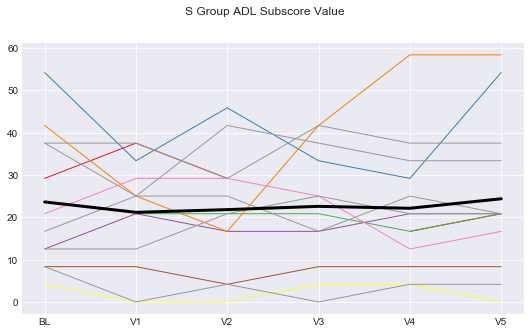

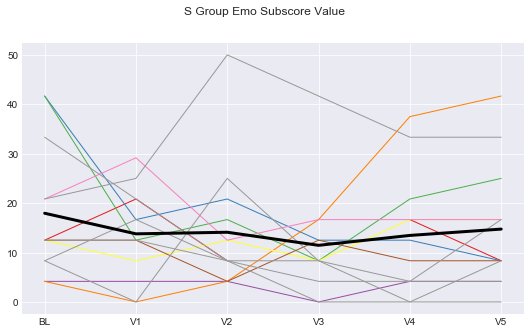

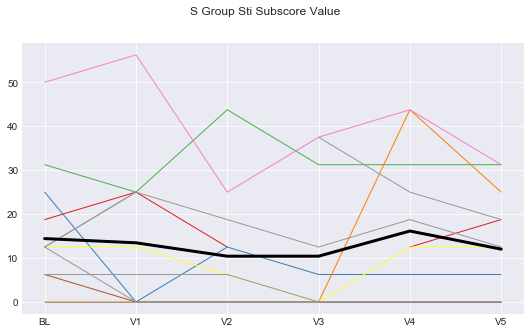

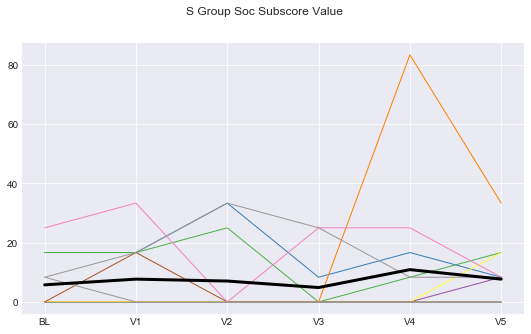

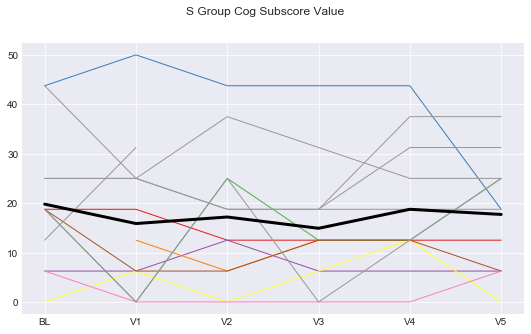

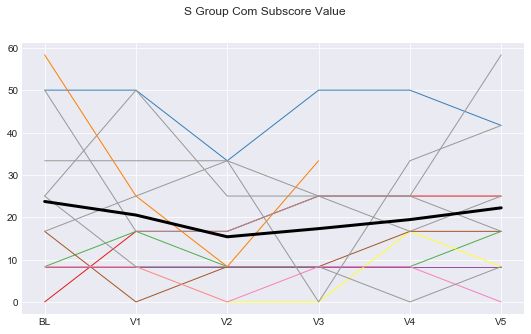

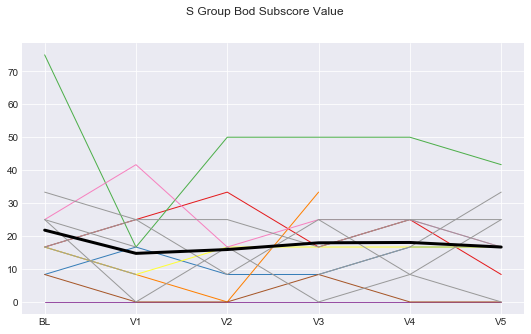

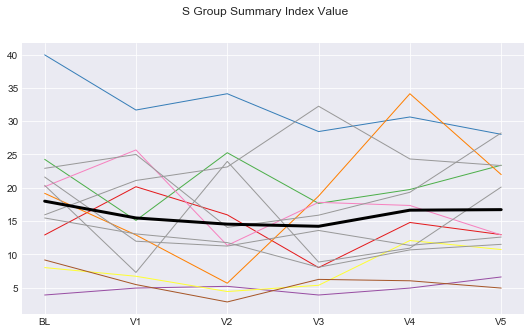

In [62]:
# Need to loop through the different subscores for each S and D
timepoints=['BL', 'V1', 'V2', 'V3', 'V4', 'V5']

# LOCF data
print('LOCF Data Plots')
for i in range(9):
    S_sub=S_pdq_locf[subscores[i]]
    # Add a row for the mean of all patients at each tp
    S_sub=S_sub.append(S_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        S_plot=S_sub.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_sub.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=8:
        plt.suptitle('S Group '+subscores[i][1][:3]+' Subscore Value')
    elif i==8:
        plt.suptitle('S Group Summary Index Value')
    plt.show()
    
# Original data
print('Original Data Plots')
for i in range(9):
    S_sub=S_pdq_orig[subscores[i]]
    # Add a row for the mean of all patients at each tp
    S_sub=S_sub.append(S_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        S_plot=S_sub.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_sub.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=8:
        plt.suptitle('S Group '+subscores[i][1][:3]+' Subscore Value')
    elif i==8:
        plt.suptitle('S Group Summary Index Value')
    plt.show()

D group - Discussion First

LOCF Data Plots


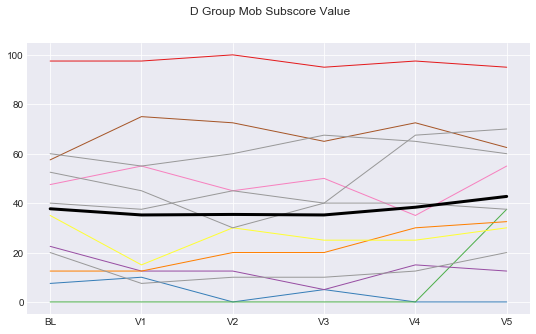

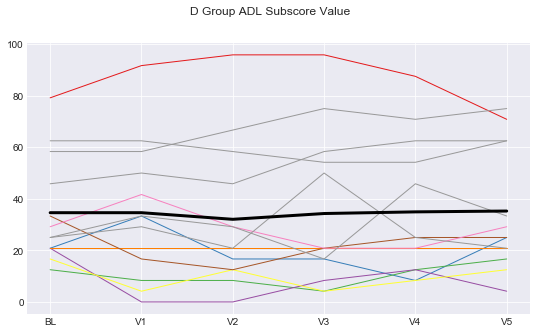

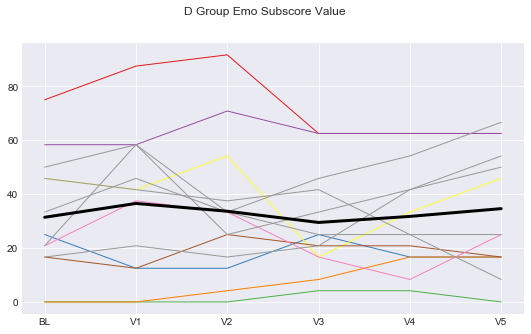

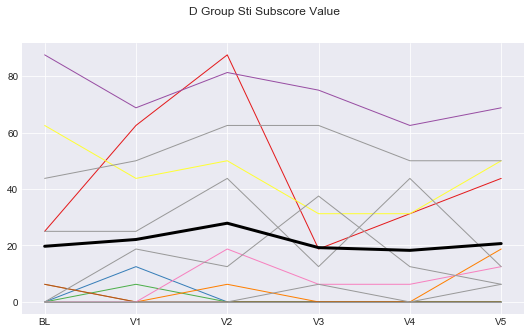

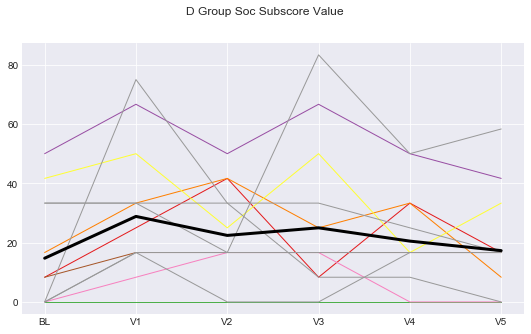

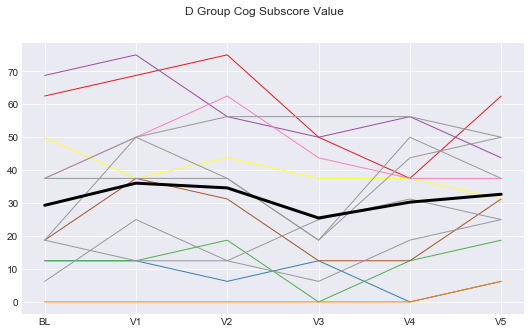

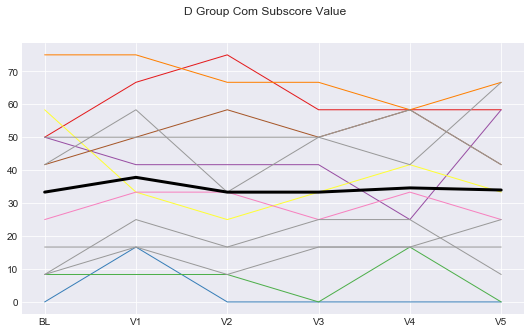

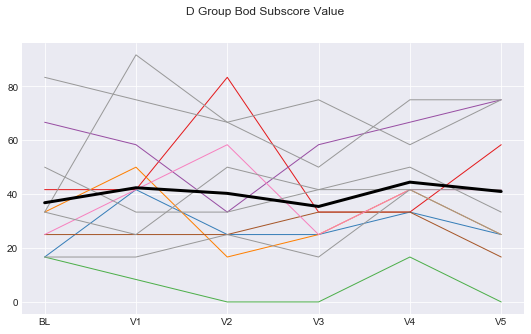

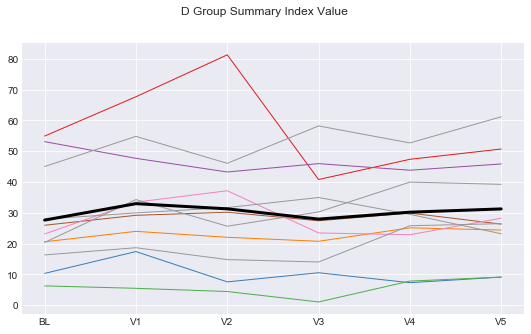

Original Data Plots


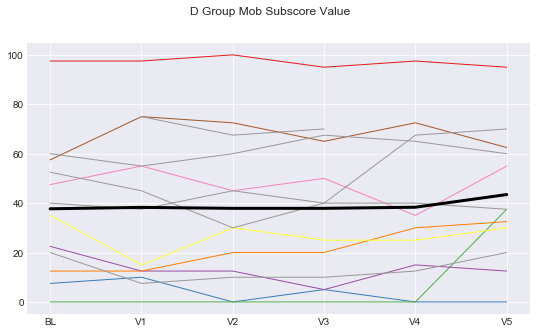

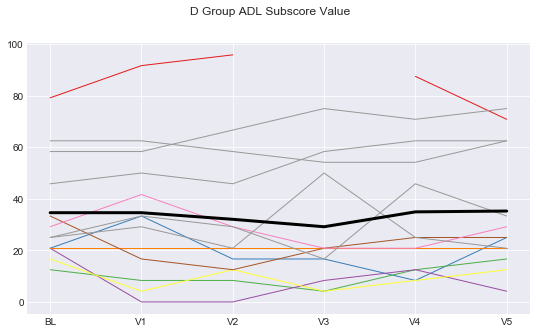

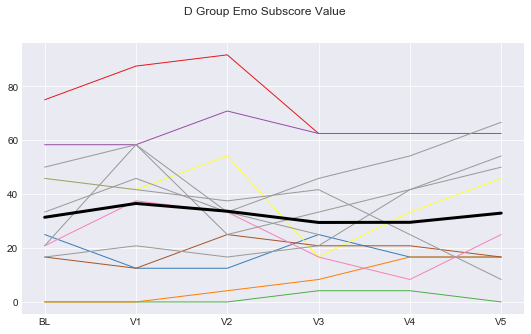

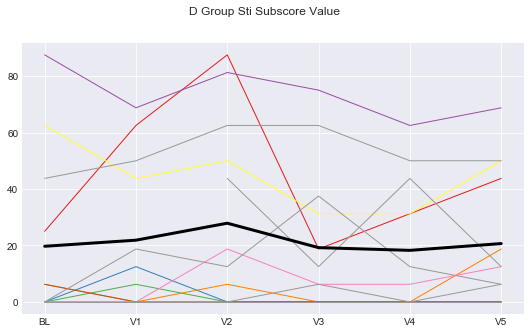

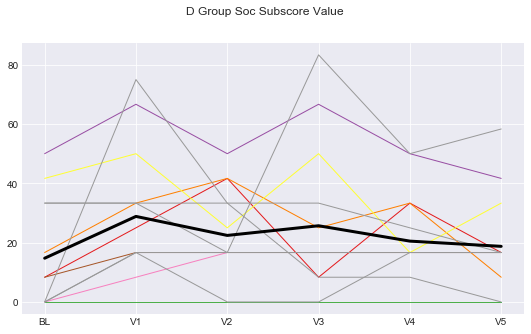

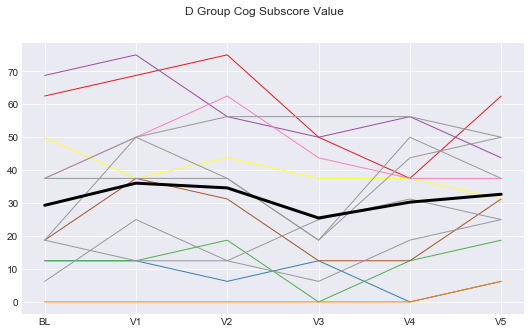

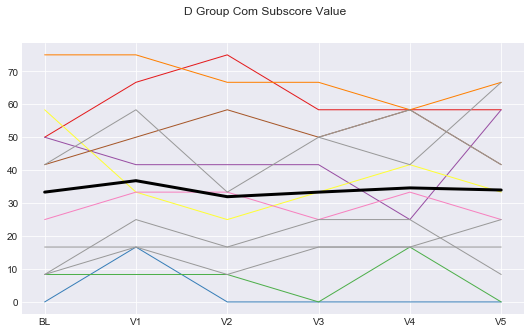

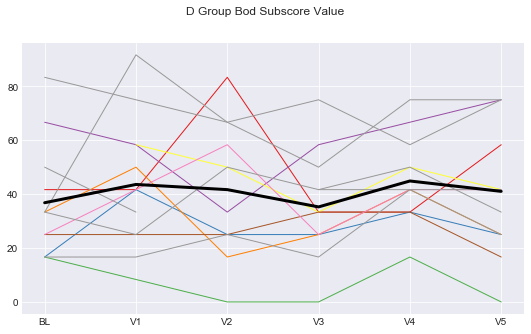

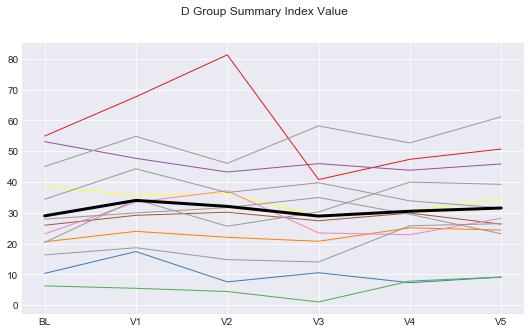

In [63]:
# LOCF data
print('LOCF Data Plots')
for i in range(9):
    D_sub=D_pdq_locf[subscores[i]]
    # Add a row fmor the mean of all patients at each tp
    D_sub=D_sub.append(D_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_sub.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_sub.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=8:
        plt.suptitle('D Group '+subscores[i][1][:3]+' Subscore Value')
    elif i==8:
        plt.suptitle('D Group Summary Index Value')
    plt.show()
    
# Original data
print('Original Data Plots')
for i in range(9):
    D_sub=D_pdq_orig[subscores[i]]
    # Add a row fmor the mean of all patients at each tp
    D_sub=D_sub.append(D_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_sub.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_sub.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=8:
        plt.suptitle('D Group '+subscores[i][1][:3]+' Subscore Value')
    elif i==8:
        plt.suptitle('D Group Summary Index Value')
    plt.show()

Comparison Data Plots
S Group Plots


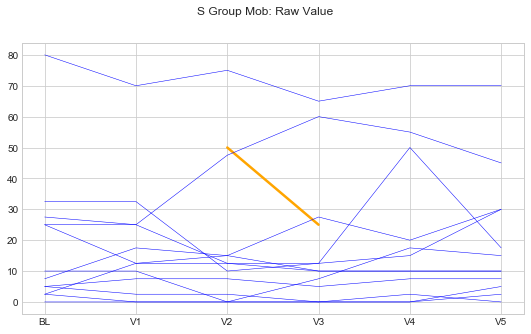

D Group Plots


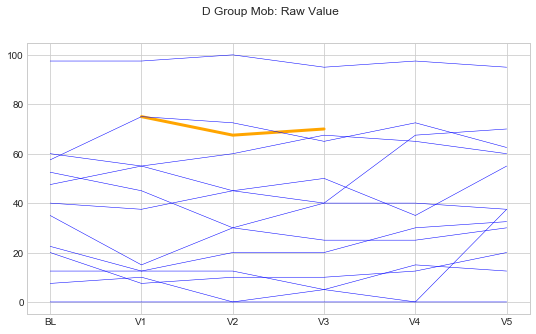

S Group Plots


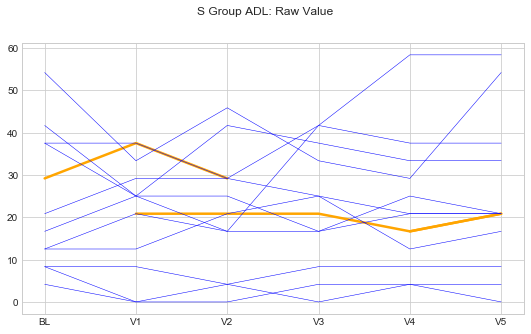

D Group Plots


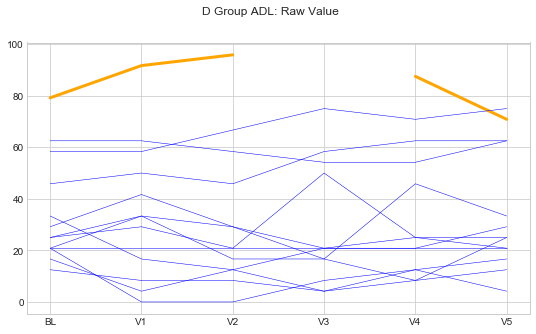

S Group Plots


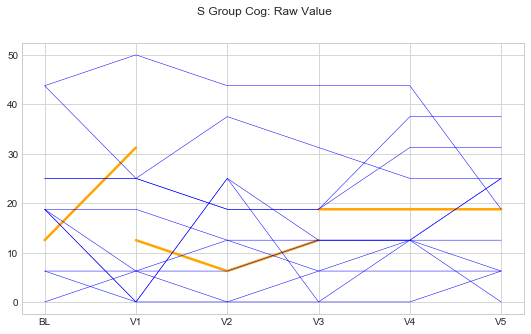

D Group Plots


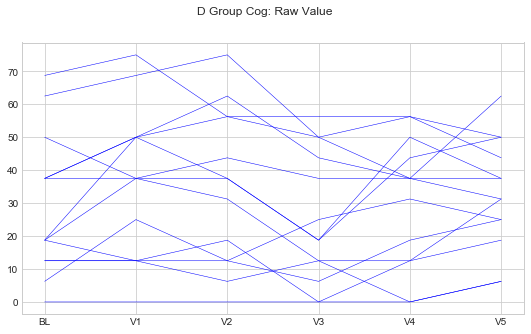

S Group Plots


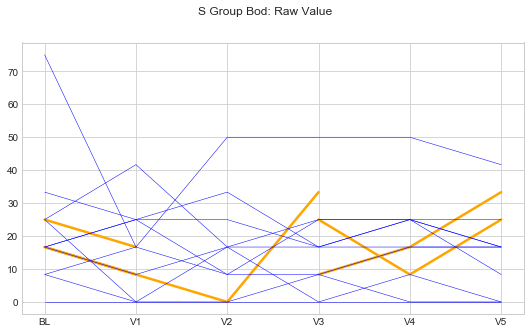

D Group Plots


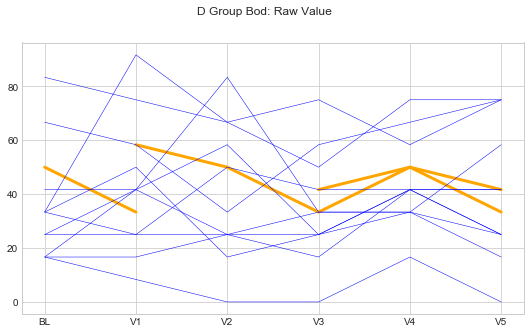

S Group Plots


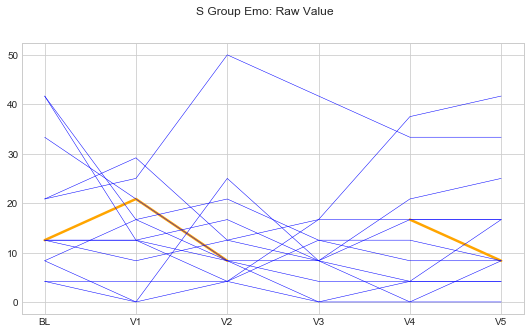

D Group Plots


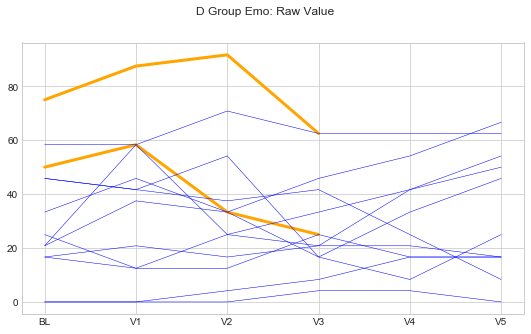

S Group Plots


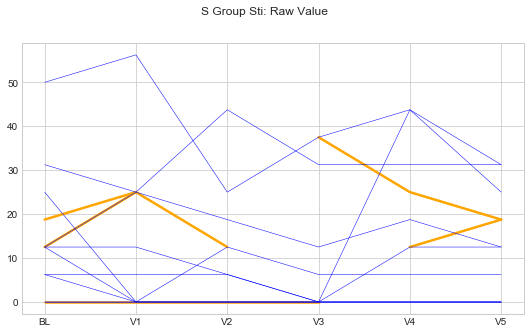

D Group Plots


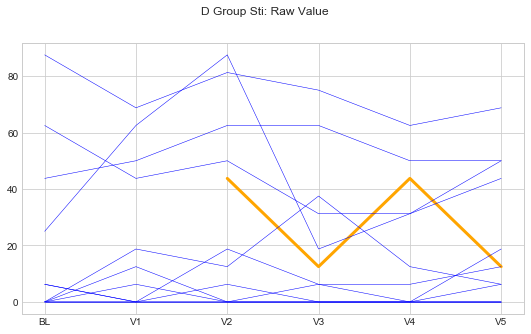

S Group Plots


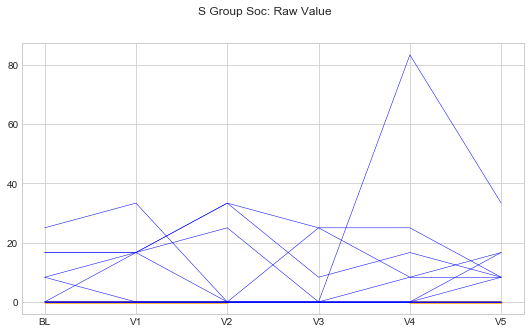

D Group Plots


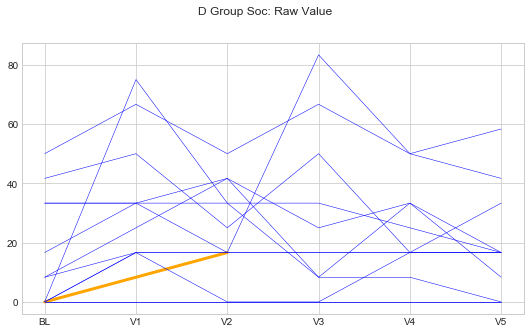

S Group Plots


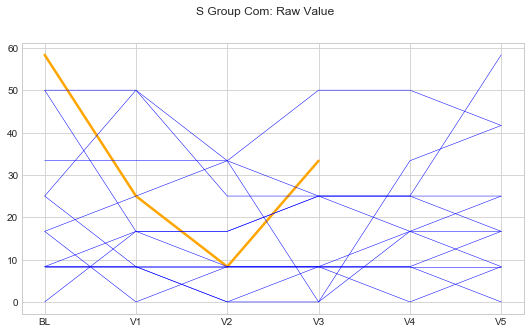

D Group Plots


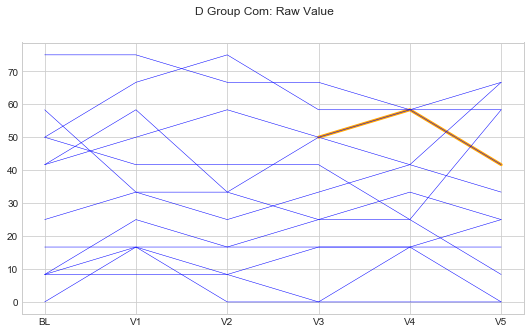

S Group Plots


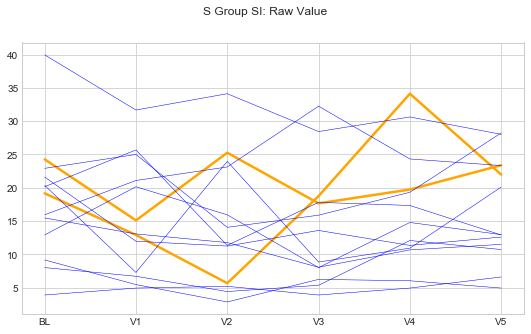

D Group Plots


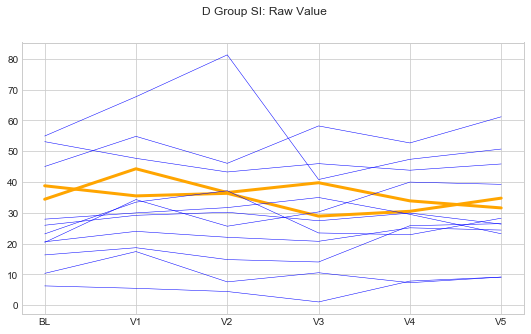

In [71]:
print('Comparison Data Plots')

count=1
for listnum in range(len(miss_sub)):
    subgroup=miss_group[listnum]
    subID=miss_ID[listnum]
    plot_sub=miss_sub[listnum]
    
    miss_S=[]
    miss_D=[]
    for j in range(len(subgroup)):
        if subgroup[j]=='S':
            miss_S.append(subID[j])
        if subgroup[j]=='D':
            miss_D.append(subID[j])
    
    plt.style.use('seaborn-whitegrid')
    palette=plt.get_cmap('Set3')
    
    print('S Group Plots')
    full_S=S_group['ID'].astype('int').tolist()
    for pnum in range(len(miss_S)):
        miss_S_plot=S_pdq_orig[subscores[plot_sub]].loc[S_pdq_orig['ID']==miss_S[pnum]].iloc[0]
        plt.plot(timepoints, miss_S_plot[1:], marker='', color='#FFA500', linewidth=2.5)
        full_S.remove(miss_S[pnum])
    for pnum in range(len(full_S)):
        full_S_plot=S_pdq_orig[subscores[plot_sub]].loc[S_pdq_orig['ID']==full_S[pnum]].iloc[0]
        plt.plot(timepoints, full_S_plot[1:], marker='', color='blue', linewidth=0.5)
      
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if plot_sub==8:
        plt.suptitle('S Group '+subscores[plot_sub][1][:2]+': Raw Value')
    else:
        plt.suptitle('S Group '+subscores[plot_sub][1][:3]+': Raw Value')
    plt.show()
    
    print('D Group Plots')
    full_D=D_group['ID'].astype('int').tolist()
    for pnum in range(len(miss_D)):
        miss_D_plot=D_pdq_orig[subscores[plot_sub]].loc[D_pdq_orig['ID']==miss_D[pnum]].iloc[0]
        plt.plot(timepoints, miss_D_plot[1:], marker='', color='#FFA500', linewidth=3)
        full_D.remove(miss_D[pnum])
    for pnum in range(len(full_D)):
        full_D_plot=D_pdq_orig[subscores[plot_sub]].loc[D_pdq_orig['ID']==full_D[pnum]].iloc[0]
        plt.plot(timepoints, full_D_plot[1:], marker='', color='blue', linewidth=0.5)
      
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if plot_sub==8:
        plt.suptitle('D Group '+subscores[plot_sub][1][:2]+': Raw Value')
    else:
        plt.suptitle('D Group '+subscores[plot_sub][1][:3]+': Raw Value')
    plt.show()
    

# Groupwise Pre-Post

Does singing better PDQ39 subscores?

Pre-post intervention: Raw value comparisons 
S: BL vs V2 and D: V2 vs V4

LOCF Data Plots


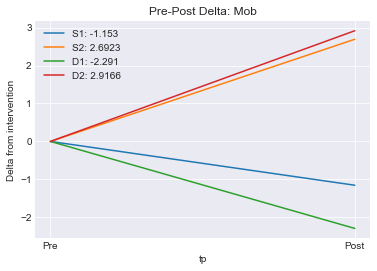

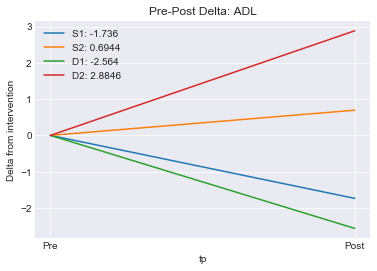

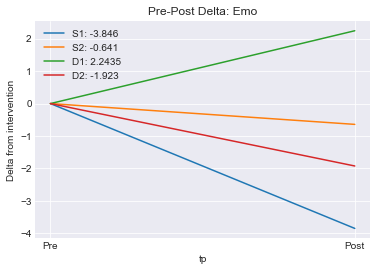

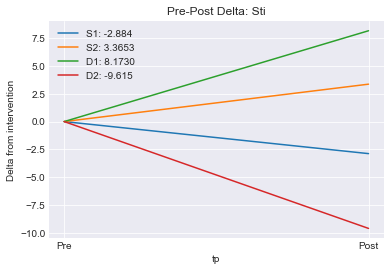

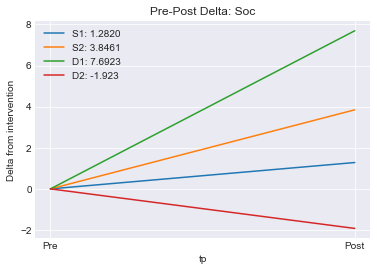

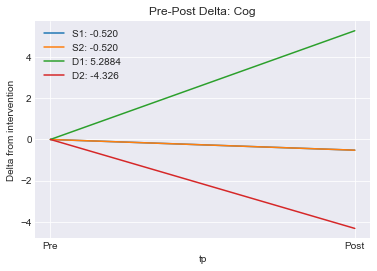

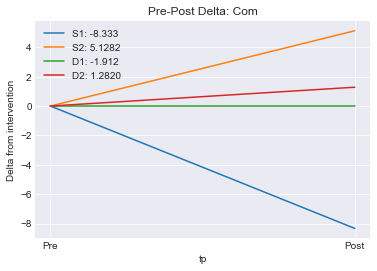

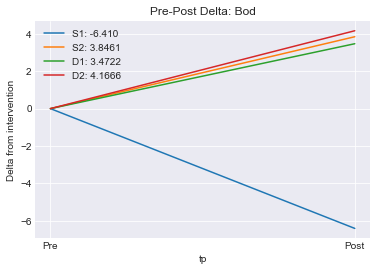

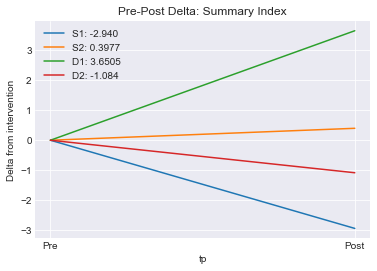

Original Data Plots


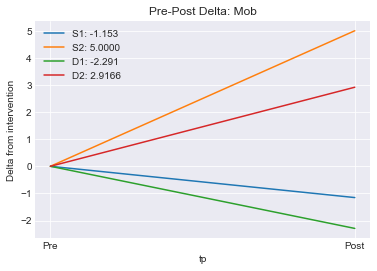

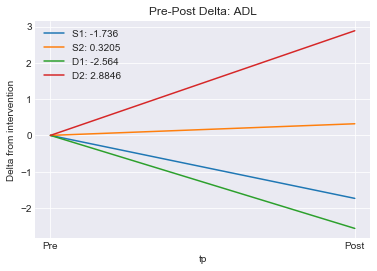

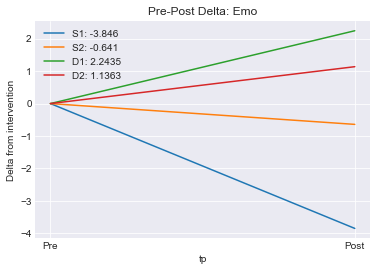

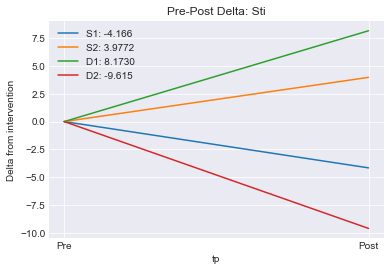

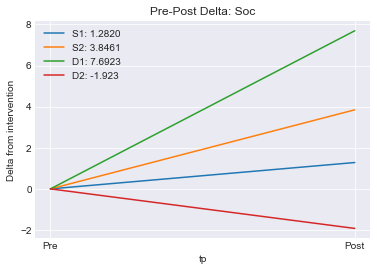

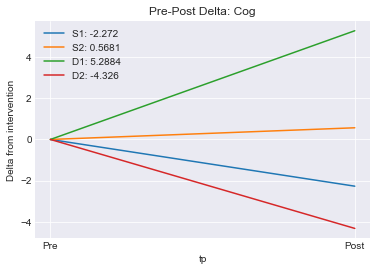

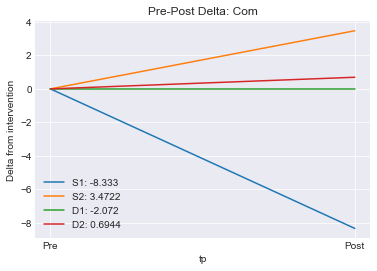

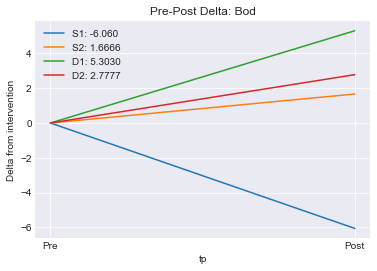

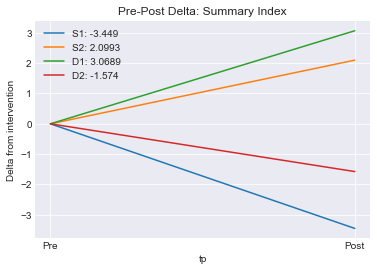

In [12]:
# Plots: want to compare gradients of the 4 groups' DELTAS
# Make lineplots of all 4 groups on one plot for eachof the voice measures

tp=['Post', 'Pre']

# LOCF Data 
print('LOCF Data Plots')
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='Summary Index'
    temp_S=S_pdq_locf[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_D=D_pdq_locf[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()
    
# Original Data 
print('Original Data Plots')
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='Summary Index'
    temp_S=S_pdq_orig[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_D=D_pdq_orig[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()

In [13]:
# Create 4 initial dfs to append to within each loop

# LOCF Data
s1_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
s2_locf=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
d1_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
d2_locf=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_locf, s2_locf, d1_locf, d2_locf]

count=1
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='Summary Index'
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_pdq=S_pdq_locf[subscores[i]].iloc[:, 1:4]
    s2_pdq=S_pdq_locf[subscores[i]].iloc[:, 4:]
    d1_pdq=D_pdq_locf[subscores[i]].iloc[:, 1:4]
    d2_pdq=D_pdq_locf[subscores[i]].iloc[:, 4:]
    pdqdflist=[s1_pdq, s2_pdq, d1_pdq, d2_pdq]

    for j in range(4):
        tempdf=tempdflist[j]
        temppdq=pdqdflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(temppdq.iloc[:, 0], temppdq.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(temppdq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(temppdq.iloc[:, 2])

        if j==0:
            s1_locf=pd.concat([s1_locf, tempdf], sort=False)
        elif j==1:
            s2_locf=pd.concat([s2_locf, tempdf], sort=False)
        elif j==2:
            d1_locf=pd.concat([d1_locf, tempdf], sort=False)
        elif j==3:
            d2_locf=pd.concat([d2_locf, tempdf], sort=False)
    count+=1
    
# Original Data
s1_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
s2_orig=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
d1_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
d2_orig=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_orig, s2_orig, d1_orig, d2_orig]

count=1
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='Summary Index'
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_pdq=S_pdq_orig[subscores[i]].iloc[:, 1:4]
    s2_pdq=S_pdq_orig[subscores[i]].iloc[:, 4:]
    d1_pdq=D_pdq_orig[subscores[i]].iloc[:, 1:4]
    d2_pdq=D_pdq_orig[subscores[i]].iloc[:, 4:]
    pdqdflist=[s1_pdq, s2_pdq, d1_pdq, d2_pdq]

    for j in range(4):
        tempdf=tempdflist[j]
        temppdq=pdqdflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(temppdq.iloc[:, 0], temppdq.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(temppdq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(temppdq.iloc[:, 2])

        if j==0:
            s1_orig=pd.concat([s1_orig, tempdf], sort=False)
        elif j==1:
            s2_orig=pd.concat([s2_orig, tempdf], sort=False)
        elif j==2:
            d1_orig=pd.concat([d1_orig, tempdf], sort=False)
        elif j==3:
            d2_orig=pd.concat([d2_orig, tempdf], sort=False)
    count+=1

LOCF results

s2, d1, d2: All resulting p-values are above 0.05. No need to correct for multiple comparisons

s1: One sub 0.05 value, correct for multiple comparisons using Simes-Hochberg

Orig results

s1, s2, d1, d2: All resulting p-values are above 0.05. No need to correct for multiple comparisons

In [14]:
# Apply Simes-Hoch method to correct FDR: step-up
# Add true/false as a column to see if reject or not
sh_s1=smt.multipletests(s1_locf.iloc[:, 1], alpha=0.05, method='sh')
s1_locf['reject H0']=sh_s1[0]
cols=['Subscore', 'pval', 'reject H0', 'BL Mean', 'V2 Mean']
s1_locf=s1_locf.loc[:, cols]


In [56]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
s1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_S1_LOCF.xlsx')
s2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_S2_LOCF.xlsx')
d1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_D1_LOCF.xlsx')
d2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_D2_LOCF.xlsx')

s1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_S1_Orig.xlsx')
s2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_S2_Orig.xlsx')
d1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_D1_Orig.xlsx')
d2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Motor Measures Analysis\PDQ39_TTest_Groupwise_D2_Orig.xlsx')

# Groupwise Delta Significance Testing

Compare deltas of S1 to S2, D1 to D2

In [15]:
# LOCF Data

# Create 4 initial dfs to append to within each loop
s_locf=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
d_locf=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
dflist=[s_locf, d_locf]

count=1
# test with mobility first
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='Summary Index'
    # Make a list of temp dataframes to iterate thru
    s_locf_temp=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
    d_locf_temp=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
    tempdflist=[s_locf_temp, d_locf_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_delta=S_pdq_locf[subscores[i]].iloc[:,3]-S_pdq_locf[subscores[i]].iloc[:,1]
    s2_delta=S_pdq_locf[subscores[i]].iloc[:,5]-S_pdq_locf[subscores[i]].iloc[:,3]
    d1_delta=D_pdq_locf[subscores[i]].iloc[:,3]-D_pdq_locf[subscores[i]].iloc[:,1]
    d2_delta=D_pdq_locf[subscores[i]].iloc[:,5]-D_pdq_locf[subscores[i]].iloc[:,3]
    deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

    for j in range(2):
        tempdf=tempdflist[j]
        delta1=deltadflist[j][0]
        delta2=deltadflist[j][1]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(delta1)
        tempdf.iloc[:, 3]=np.mean(delta2)

        if j==0:
            s_locf=pd.concat([s_locf, tempdf], sort=False)
        elif j==1:
            d_locf=pd.concat([d_locf, tempdf], sort=False)
    count+=1
    
# Original Data

# Create 4 initial dfs to append to within each loop
s_orig=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
d_orig=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
dflist=[s_orig, d_orig]

count=1
# test with mobility first
for i in range(9):
    if i!=8:
        scorename=subscores[i][1][:3]
    elif i==8:
        scorename='Summary Index'
    # Make a list of temp dataframes to iterate thru
    s_orig_temp=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
    d_orig_temp=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
    tempdflist=[s_orig_temp, d_orig_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_delta=S_pdq_orig[subscores[i]].iloc[:,3]-S_pdq_orig[subscores[i]].iloc[:,1]
    s2_delta=S_pdq_orig[subscores[i]].iloc[:,5]-S_pdq_orig[subscores[i]].iloc[:,3]
    d1_delta=D_pdq_orig[subscores[i]].iloc[:,3]-D_pdq_orig[subscores[i]].iloc[:,1]
    d2_delta=D_pdq_orig[subscores[i]].iloc[:,5]-D_pdq_orig[subscores[i]].iloc[:,3]
    deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

    for j in range(2):
        tempdf=tempdflist[j]
        delta1=deltadflist[j][0]
        delta2=deltadflist[j][1]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(delta1)
        tempdf.iloc[:, 3]=np.mean(delta2)

        if j==0:
            s_orig=pd.concat([s_orig, tempdf], sort=False)
        elif j==1:
            d_orig=pd.concat([d_orig, tempdf], sort=False)
    count+=1

In [18]:
S_pdq_orig

,ID,Mobility_BL,Mobility_V01,Mobility_V02,Mobility_V03,Mobility_V04,Mobility_V05,ADL_BL,ADL_V01,ADL_V02,ADL_V03,ADL_V04,ADL_V05,EmotionalWell_BL,EmotionalWell_V01,EmotionalWell_V02,EmotionalWell_V03,EmotionalWell_V04,EmotionalWell_V05,Stigma_BL,Stigma_V01,Stigma_V02,Stigma_V03,Stigma_V04,Stigma_V05,SocialSupport_BL,SocialSupport_V01,SocialSupport_V02,SocialSupport_V03,SocialSupport_V04,SocialSupport_V05,CognitiveImp_BL,CognitiveImp_V01,CognitiveImp_V02,CognitiveImp_V03,CognitiveImp_V04,CognitiveImp_V05,Communication_BL,Communication_V01,Communication_V02,Communication_V03,Communication_V04,Communication_V05,BodyDiscomfort_BL,BodyDiscomfort_V01,BodyDiscomfort_V02,BodyDiscomfort_V03,BodyDiscomfort_V04,BodyDiscomfort_V05,SI_BL,SI_V01,SI_V02,SI_V03,SI_V04,SI_V05,Age,Gender,Hoehn & Yahr,First Intervention
4,24908,7.5,17.5,15.0,10.0,10.0,10.0,29.166667,37.500000,29.166667,NaN,16.666667,20.833333,12.500000,20.833333,8.333333,NaN,16.666667,8.333333,18.75,25.00,12.50,NaN,12.50,18.75,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,18.75,18.75,12.50,12.50,12.50,12.50,0.000000,16.666667,16.666667,25.000000,25.000000,25.000000,16.666667,25.000000,33.333333,16.666667,25.000000,8.333333,12.916667,20.156250,15.937500,8.020833,14.791667,12.968750,67.0,M,2.0,S
7,33419,80.0,70.0,75.0,65.0,70.0,70.0,54.166667,33.333333,45.833333,33.333333,29.166667,54.166667,41.666667,16.666667,20.833333,12.500000,12.500000,8.333333,25.00,0.00,12.50,6.25,6.25,6.25,16.666667,16.666667,33.333333,8.333333,16.666667,8.333333,43.75,50.00,43.75,43.75,43.75,18.75,50.000000,50.000000,33.333333,50.000000,50.000000,41.666667,8.333333,16.666667,8.333333,8.333333,16.666667,16.666667,39.947917,31.666667,34.114583,28.437500,30.625000,28.020833,82.0,M,3.0,S
8,35303,2.5,12.5,12.5,10.0,10.0,10.0,NaN,20.833333,20.833333,20.833333,16.666667,20.833333,41.666667,12.500000,16.666667,8.333333,20.833333,25.000000,31.25,25.00,43.75,31.25,31.25,31.25,16.666667,16.666667,25.000000,0.000000,8.333333,16.666667,18.75,0.00,25.00,12.50,12.50,25.00,8.333333,16.666667,8.333333,8.333333,8.333333,16.666667,75.000000,16.666667,50.000000,50.000000,50.000000,41.666667,24.270833,15.104167,25.260417,17.656250,19.739583,23.385417,63.0,M,2.0,S
11,63613,0.0,0.0,0.0,0.0,0.0,5.0,12.500000,20.833333,16.666667,16.666667,20.833333,20.833333,4.166667,4.166667,4.166667,0.000000,4.166667,4.166667,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,8.333333,6.25,6.25,12.50,6.25,6.25,6.25,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.906250,4.947917,5.208333,3.906250,4.947917,6.614583,80.0,M,2.0,S
12,63908,32.5,32.5,10.0,12.5,50.0,17.5,41.666667,25.000000,16.666667,41.666667,58.333333,58.333333,4.166667,0.000000,4.166667,16.666667,37.500000,41.666667,0.00,0.00,0.00,0.00,43.75,25.00,0.000000,0.000000,0.000000,0.000000,83.333333,33.333333,NaN,12.50,6.25,12.50,NaN,NaN,58.333333,25.000000,8.333333,33.333333,NaN,NaN,16.666667,8.333333,0.000000,33.333333,NaN,NaN,19.166667,12.916667,5.677083,18.750000,34.114583,21.979167,76.0,M,3.0,S
13,64205,10.0,10.0,0.0,7.5,17.5,15.0,4.166667,0.000000,0.000000,4.166667,4.166667,0.000000,12.500000,8.333333,12.500000,8.333333,16.666667,16.666667,12.50,12.50,6.25,0.00,12.50,12.50,0.000000,0.000000,0.000000,0.000000,0.000000,16.666667,0.00,6.25,0.00,6.25,12.50,0.00,8.333333,8.333333,0.000000,0.000000,16.666667,8.333333,16.666667,8.333333,16.666667,16.666667,16.666667,16.666667,8.020833,6.718750,4.427083,5.364583,12.083333,10.729167,74.0,M,2.0,S
14,64922,2.5,0.0,0.0,0.0,2.5,0.0,8.333333,8.333333,4.166667,8.333333,8.333333,8.333333,12.500000,12.500000,4.166667,12.500000,8.333333,8.333333,6.25,0.00,0.00,0.00,0.00,0.00,0.000000,16.666667,0.000000,0.000000,0.000000,0.000000,18.75,6.25,6.25,12.50,12.50,6.25,16.666667,0.000000,8.333333,8.333333,16.666667,16.666667,8.333333,0.000000,0.000000,8.333333,0.000000,0.000000,9.166667,5.468750,2.864583,6.250000,6.041667,4.947917,67.0,M,2.0,S
15,65202,5.0,7.5,7.5,5.0,7.5

In [106]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
s_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\PDQ39\LOCF\PDQ39_TTest_SDelta.xlsx')
d_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\PDQ39\LOCF\PDQ39_TTest_DDelta.xlsx')
s_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\PDQ39\Original\PDQ39_TTest_SDelta.xlsx')
d_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\PDQ39\Original\PDQ39_TTest_DDelta.xlsx')